# Hotel Booking Demand Analysis & Cancelation prediction

* [Chapter 1](#chapter1)
    * [Section 1.1](#section-1-a)
    * [Section 2.1](#section-2-1)

## 1) Introduction

### Dataset description

### Aims

_"Hotels currently don’t know about the guests' preferences, booking / cancelation patterns, deeper
insights etc."_

_"It would be nicer for the hotels to have a model to predict if a guest will come."_

- Describe data using descriptive statistics
- Conceptualise and describe use cases from perspective of hotel owner
- Suggest use cases from perspective of hotel guests
- __Analytics models to be developed__:
    - Unsupervised model - to provide hidden insights 
    - Classification model - to predict cancellation of bookings
    - Regression model - to predict number of booking nights for any new booking

### Hypotheses

- Given in powerpoint presentation: 
    - Best time of year to book a room?
    - Optimal length of stay for the best daily rate?
    - Whether or not a hotel is likely to receive a disproportionately high number of special requests
    - The probability of a booking getting cancelled
- Additional:
    - Is there a season guests prefer to book at hotel room for? 
    - On which factors does the preference for type of hotel depend?
    - Which type of hotel is a family likely to book, plus what length of stay, and through which distribution channels? 

## 2) Python Libraries

__Requires Python >=3.8__ to be installed, ideally in a virtual environment created with venv or pyenv-virtualenv.

In [1]:
# !pip install -r requirements.txt

In [2]:
import calendar
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set(style="ticks", font_scale=0.8)

## 3) Data Preparation <a class="anchor" id="section-2-1"></a>

In [3]:
df = pd.read_csv('hotel_bookings.csv')

### Dataset overview

The original dataset contains 32 variables, 20 of which can be considered categorical, five are dates or date-like objects, and seven can be considered continuous. There are a total of _119,390_ records.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Dataset sample

In [5]:
df.sample(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
105654,City Hotel,0,33,2017,February,6,9,1,3,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,7.0,NaN,0,Transient,60.94,0,1,Check-Out,2017-02-13
87457,City Hotel,0,5,2016,April,17,19,0,1,2,0.0,0,SC,ESP,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,89.00,0,0,Check-Out,2016-04-20
12207,Resort Hotel,1,28,2017,June,25,18,1,0,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,F,F,0,No Deposit,241.0,NaN,0,Transient,136.00,0,1,Canceled,2017-05-21


### Identifying missing values

Four columns contain one or more records with null/NA/nan values: _company_, _agent_, _country_, _children_. These need to be cleaned, transformed, and/or removed.

In [6]:
df.isnull().sum().sort_values(ascending=False)[:4]  # Remove square brackets at end to show data for all columns

company     112593
agent        16340
country        488
children         4
dtype: int64

### Identifying negative values in numeric columns

Of all numeric columns, only '_adr_' (average daily rate) contains negative values. As only one record in the '_adr_' variable is negative, and since it is unlikely this var should be negative, and since this variable is considered important, it is permissable to drop this record from the dataset for now, as it is likely an error.

In [7]:
contains_negative = []
from pandas.api.types import is_numeric_dtype
for var in df:
    if is_numeric_dtype(df[var]):       
        if (df[var].values < 0).any():
            contains_negative.append(var)
contains_negative

['adr']

In [8]:
df[df['adr'] < 0]['adr']

14969   -6.38
Name: adr, dtype: float64

In [9]:
df.drop(14969, inplace=True)

## 4) Univariate Analysis

Boxplots of all continous variables will be created next. These visualise the characteristic of each distribution, with particular focus on outliers and extreme values.

The '_adr_' variable contains one extreme outlier with a value of 5,400. It is unlikely the daily rate could be this exessive, and this record will be removed from the dataset. The remaining continous variables contain some outliers/extreme values, but these can be considered 'expected' under some circumstances (e.g. public holidays). After the extreme outlier was removed, the distribution of the variable is improved, although some outliers are still present in the interval larger than 400. Since these could be related to various factors such as holiday pricing, last minute, or large groups, these will be left in for now.

In [10]:
def boxplot(df, var, ax, axis_r=-1, axis_c=-1, log=False):
    """Create a boxplot visualisation with seaborn.    
    """
    if axis_r >= 0 and axis_c >= 0: 
        coords = (axis_r, axis_c)  
    elif axis_r >= 0 and axis_c == -1:
        coords = axis_r        
    if log:
        ax[coords].set_xscale("log")           
    ax[coords].grid(True)    
    sns.boxplot(ax=ax[coords], x=df[var], data=df, width=.6, palette="vlag")
    sns.stripplot(ax=ax[coords], x=df[var], data=df, size=1, color="0.9", linewidth=0, alpha=0.05)
    ax[coords].set(ylabel="")
    ax[coords].set(xlabel=f"Variable: {var}")
    ax[coords].xaxis.set_ticks_position('bottom')
    ax[coords].xaxis.set_label_position('top')

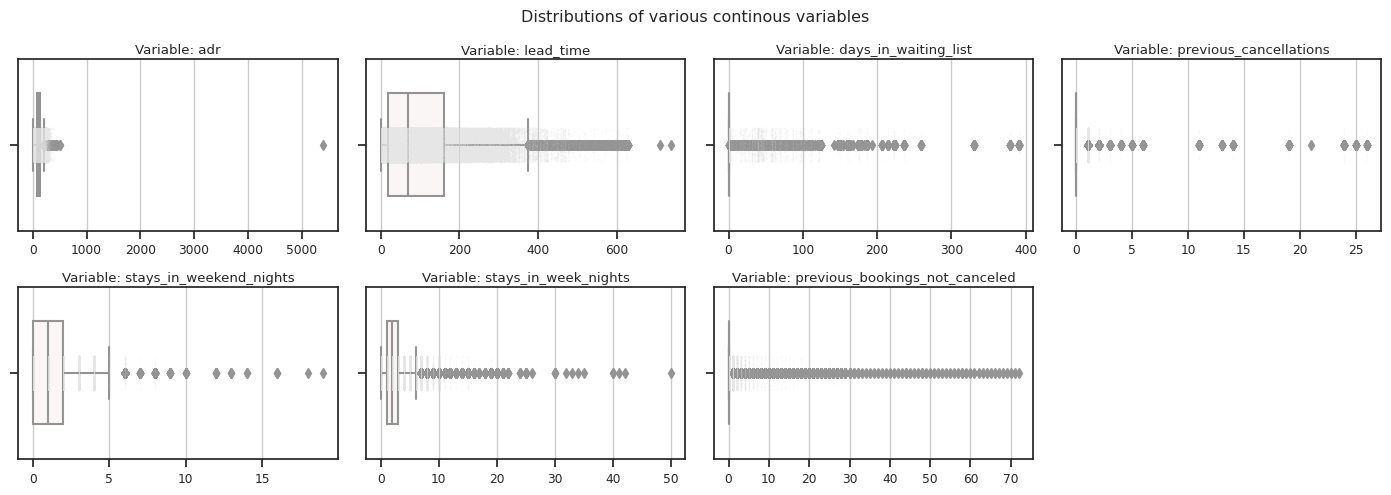

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(14, 5), sharey=True)
fig.suptitle("Distributions of various continous variables")
boxplot(df, 'adr', ax, axis_r=0, axis_c=0, log=False)
boxplot(df, 'lead_time', ax, 0, 1)
boxplot(df, 'days_in_waiting_list', ax, 0, 2)
boxplot(df, 'previous_cancellations', ax, 0, 3)
boxplot(df, 'stays_in_weekend_nights', ax, 1, 0)
boxplot(df, 'stays_in_week_nights', ax, 1, 1)
boxplot(df, 'previous_bookings_not_canceled', ax, 1, 2)
ax[1,3].set_axis_off()
plt.tight_layout()

In [12]:
df[df['adr'] > 5000]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
48515,City Hotel,1,35,2016,March,13,25,0,1,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,Non Refund,12.0,NaN,0,Transient,5400.0,0,0,Canceled,2016-02-19


In [13]:
df.drop(48515, inplace=True)

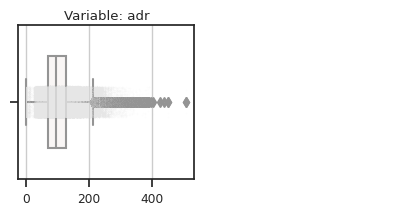

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2), sharey=True)
boxplot(df, 'adr', ax, 0)
ax[1].set_axis_off()

## 5) More data cleaning & feature engineering

### Perform various adjustments and create new feature columns.

- The variables indicating the arrival time and dates need to be changed to datetime type, and combined into one variable, called '_arrival_date_'. 
- Similarly, the _reservation_status_date_ needs to be changed to type datetime as well. 
- The '_hotel_' variable can be changed to numeric type, which makes it easier to use later on. 
- It is also assumed that records with a company are business customers, and records without a company are not. While this might be a simplicfication, and at times wrong, this prevents having to remove all records where a company was not give, which would reduce dataset size. 
- Similarly, it is assumed that records with an agent indicated use an agent, while records without an agent did not use one. As before, this is a simplificiation, but will prevent removal of records.
- Country
- Total stays
- Checkout date

In [15]:
df['arrival_date_month'] = pd.to_datetime(df.arrival_date_month, format='%B').dt.month
df['arrival_date'] = pd.to_datetime(df[['arrival_date_day_of_month',
                                        'arrival_date_month', 
                                        'arrival_date_year']]
                   .astype(str).apply(' '.join, 1), format='%d %m %Y')
df.drop(['arrival_date_year', 'arrival_date_month', 
         'arrival_date_week_number', 'arrival_date_day_of_month'], inplace=True, axis=1)

df['reservation_status_date'] = pd.to_datetime(df.reservation_status_date, format='%Y-%m-%d')

df['hotel'] = np.where(df['hotel'] == 'Resort Hotel', 0, 1)

df['business_customer'] = np.where(df['company'].notnull(), True, False)
df.drop('company', inplace=True, axis=1)

df['agent'] = np.where(df['agent'].notnull(), True, False)
df.drop(df[df.adults <= 0].index, inplace=True)

df['children'] = np.where(df['children'].astype('Int64').isnull(), 0, df['children']).astype('int64')

df['country'] = np.where(df['country'].isnull(), "UNKNOWN", df['country'])

df['total_stays'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

df['checkout_date'] = df['arrival_date'] + df['total_stays'].astype('timedelta64[D]')

### Add 'stay_is_public_holiday_' variable

In [48]:
countries = pd.read_csv("iso_codes_countries.csv", usecols=['name', 'alpha-2', 'alpha-3'])

holidays = pd.read_csv("public-holidays.csv", usecols=['date', 'countryRegionCode'])
holidays['date'] = pd.to_datetime(holidays['date'], format='%Y-%m-%d')
holidays.columns = ['alpha-2', 'date']
holidays = holidays.merge(countries, on='alpha-2')
holidays = holidays[['date', 'name', 'alpha-2', 'alpha-3']]

df['date_range'] = df.apply(lambda x: pd.date_range(x['arrival_date'], x['checkout_date']).strftime('%Y-%m-%d').to_list(), axis=1)

country_holidays = dict()
for country in holidays['alpha-3'].unique():
    date_array = holidays[holidays['alpha-3'] == country]['date'].to_list()
    date_list = [x.strftime('%Y-%m-%d') for x in date_array]
    country_holidays[country] = date_list
    
def stay_is_public_holiday(date_range, country):   
    try:
        return 1 if any(np.isin(date_range, country_holidays[country])) else 0
    except:
        return 0
    
df['stay_is_public_holiday'] = df.apply(lambda x: stay_is_public_holiday(x.date_range, x.country), axis=1)
df.drop('date_range', axis=1, inplace=True)

## 6) Bivariate Analysis

### Total bookings

In [17]:
booked_arrivals_per_month = df.arrival_date.dt.month.value_counts(sort=False).reset_index()
booked_arrivals_per_month.columns = ['Month', '# of bookings']
booked_arrivals_per_month.sort_values(by='Month', ascending=True, inplace=True)
booked_arrivals_per_month['Month'] = booked_arrivals_per_month['Month'].apply(lambda x: calendar.month_abbr[x])

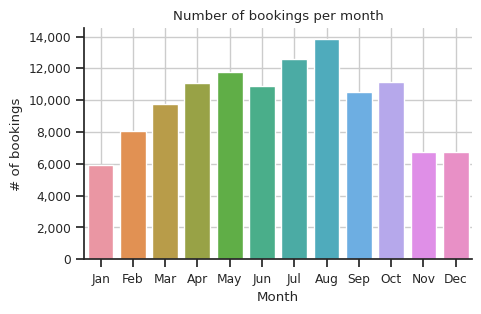

In [18]:
fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(x='Month', y="# of bookings", data=booked_arrivals_per_month)
sns.despine(left=False, bottom=False)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Number of bookings per month")
ax.grid()

### Number of total bookings per country

In [19]:
bookings_per_country = df['country'].value_counts().reset_index()
bookings_per_country.columns = ['Country', '# of bookings']

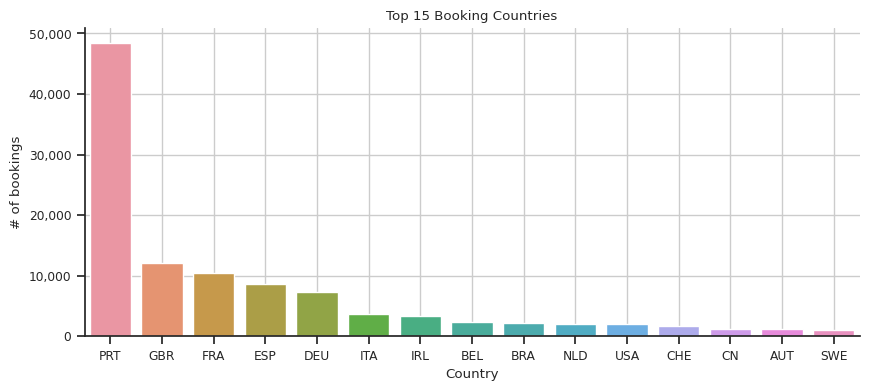

In [20]:
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(y='# of bookings', x="Country", data=bookings_per_country[:15])
sns.despine(left=False, bottom=False)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Top 15 Booking Countries")
ax.grid()

### Cancellations

In [21]:
cancellations_per_month = pd.DataFrame(df.groupby(df.arrival_date.dt.month)['is_canceled'].sum()).reset_index()
cancellations_per_month.columns = ["Month", "# of cancellations"]
cancellations_per_month['Month'] = cancellations_per_month['Month'].apply(lambda x: calendar.month_abbr[x])
# cancellations_per_month.sort_values(by=['# of cancellations'], ascending=False, inplace=True)
cancellations_per_month.reset_index(inplace=True, drop=True)

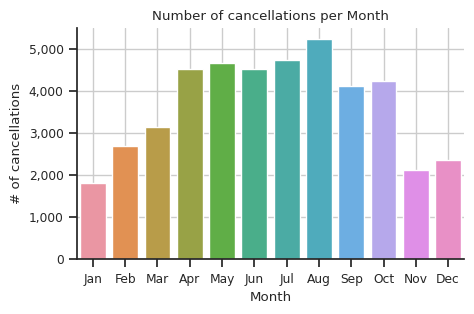

In [22]:
fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(x='Month', y="# of cancellations", data=cancellations_per_month)
sns.despine(left=False, bottom=False)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Number of cancellations per Month")
ax.grid()

### Cancellations per country

In [23]:
cancellations_per_country = pd.DataFrame(df.groupby(['country'])['is_canceled'].sum()).reset_index()
cancellations_per_country.columns = ['Country', '# of cancellations']
cancellations_per_country.sort_values(by=['# of cancellations'], ascending=False, inplace=True)

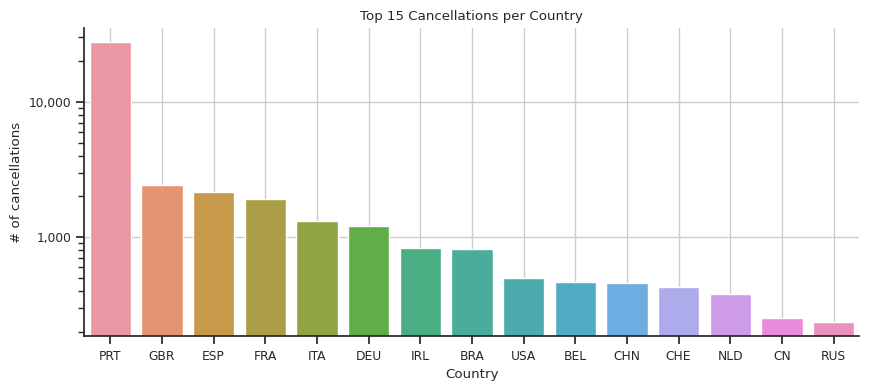

In [24]:
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(y='# of cancellations', x="Country", data=cancellations_per_country[:15], log=True)
sns.despine(left=False, bottom=False)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Top 15 Cancellations per Country")
ax.grid()

__The majority of bookings came from Portugal itself, followed by other European countries, including Great Britain, France, Spain and Germany. Brasil is the only Non-European country in the top 10.__

### Number of guests per country that consumed their stay

In [25]:
guests_per_country = df[df['is_canceled'] == 0]['country'].value_counts().reset_index()
guests_per_country.columns = ['Country', '# of guests']

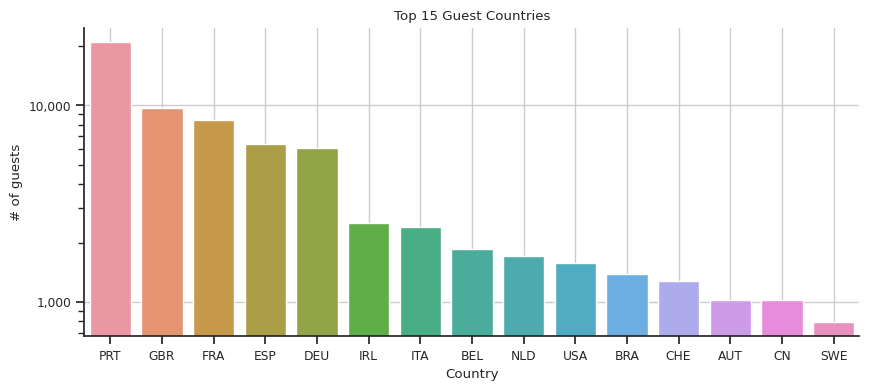

In [26]:
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(y='# of guests', x="Country", data=guests_per_country[:15], log=True)
sns.despine(left=False, bottom=False)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Top 15 Guest Countries")
ax.grid()

### Holidays

In [106]:
hotel_vs_holiday = df[['hotel', 'stay_is_public_holiday']]
hotel_vs_holiday = pd.DataFrame(hotel_vs_holiday.groupby('hotel')['stay_is_public_holiday'].value_counts())
hotel_vs_holiday.columns = ['counts']
hotel_vs_holiday.reset_index(inplace=True)
hotel_vs_holiday['hotel'] = np.where(hotel_vs_holiday['hotel'] == 0, 'Resort Hotel', 'City Hotel')
hotel_vs_holiday['stay_is_public_holiday'] = np.where(hotel_vs_holiday['stay_is_public_holiday'] == 0, 'No', 'Yes')

cancellation_vs_holiday = df[['is_canceled', 'stay_is_public_holiday']]
cancellation_vs_holiday = pd.DataFrame(cancellation_vs_holiday.groupby('is_canceled')['stay_is_public_holiday'].value_counts())
cancellation_vs_holiday.columns = ['counts']
cancellation_vs_holiday.reset_index(inplace=True)
cancellation_vs_holiday['is_canceled'] = np.where(cancellation_vs_holiday['is_canceled'] == 0, 'No', 'Yes')
cancellation_vs_holiday['stay_is_public_holiday'] = np.where(cancellation_vs_holiday['stay_is_public_holiday'] == 0, 'No', 'Yes')

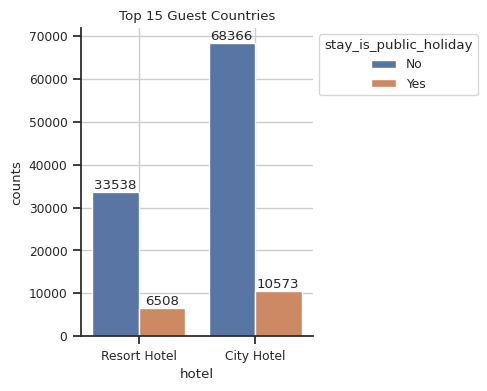

In [107]:
fig, ax = plt.subplots(figsize=(3,4))
sns.barplot(x='hotel', y='counts', hue='stay_is_public_holiday', data=hotel_vs_holiday)
sns.despine(left=False, bottom=False)
ax.set_title("Top 15 Guest Countries")
ax.grid()
for container in ax.containers:
    ax.bar_label(container)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

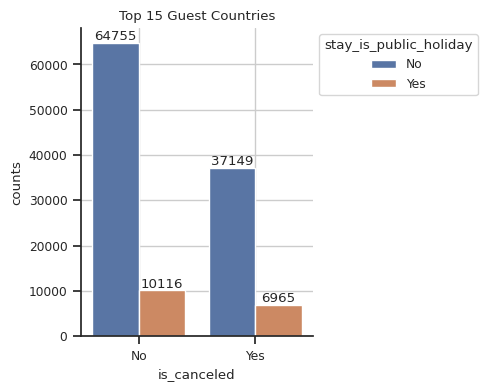

In [112]:
fig, ax = plt.subplots(figsize=(3,4))
sns.barplot(x='is_canceled', y='counts', hue='stay_is_public_holiday', data=cancellation_vs_holiday)
sns.despine(left=False, bottom=False)
ax.set_title("Top 15 Guest Countries")
ax.grid()
for container in ax.containers:
    ax.bar_label(container)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))